In [1]:
!pip install adversarial-robustness-toolbox # ART 라이브러리 설치

In [2]:
# 라이브러리 임포트 및 Fashion MNIST 로드/전처리
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import random
import numpy as np
import tensorflow as tf
import os

def set_global_seed(seed=42):
    # 1. Python 기본 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    
    # 2. Numpy 시드 고정
    np.random.seed(seed)
    
    # 3. TensorFlow 시드 고정
    tf.random.set_seed(seed)

set_global_seed(42)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist # Fashion MNIST


import pandas as pd
import matplotlib.pyplot as plt
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod # FGSM 공격
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer # 적대적 훈련

# 1. 데이터 로드 (Fashion MNIST)
print(">>> Fashion MNIST 데이터 셋")
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 2. 전처리
# (1) 차원 추가 및 정규화: (N, 28, 28) -> (N, 28, 28, 1) 로 변경 및 0~1 정규화
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# (2) One-hot Encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


min_pixel_value, max_pixel_value = 0.0, 1.0
print(f"훈련 데이터 형태: {x_train.shape}")
print(f"평가 데이터 형태: {x_test.shape}")

>>> Fashion MNIST 데이터 셋
훈련 데이터 형태: (60000, 28, 28, 1)
평가 데이터 형태: (10000, 28, 28, 1)


In [3]:
# Fashion MNIST용 CNN 모델 정의

def create_cnn_model():
    model = Sequential([
        # 입력층 (28x28x1)
        Input(shape=(28, 28, 1)),

        # 블록 1
        Conv2D(32, kernel_size=(3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # 블록 2
        Conv2D(64, kernel_size=(3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # 분류기 (Classifier) 부분
        Flatten(),
        
        #중간 은닉층
        Dense(128, activation='relu'), 
        
        # 과적합 방지 드롭아웃
        Dropout(0.3), 

        # 최종 출력층 (10개 클래스)
        Dense(10, activation='softmax')
    ])

    # Adam 옵티마이저 (학습률 0.001)
    model.compile(loss=categorical_crossentropy, 
                  optimizer=Adam(learning_rate=0.0001), 
                  metrics=['accuracy'])
    
    return model



>>> 에포크별 성능 측정 (5 ~ 30)...
Testing Epoch 5... -> Accuracy: 87.61%
Testing Epoch 10... -> Accuracy: 89.25%
Testing Epoch 15... -> Accuracy: 89.69%
Testing Epoch 20... -> Accuracy: 90.79%
Testing Epoch 25... -> Accuracy: 91.03%
Testing Epoch 30... -> Accuracy: 91.56%

 Best Result: Epoch 30 (Accuracy: 91.56%)

[Base Model (Epoch 30) 클래스별 상세 정확도]
T-shirt/top     | 88.20%
Trouser         | 98.30%
Pullover        | 91.00%
Dress           | 93.20%
Coat            | 87.80%
Sandal          | 97.70%
Shirt           | 68.00%
Sneaker         | 98.50%
Bag             | 98.20%
Ankle boot      | 94.70%


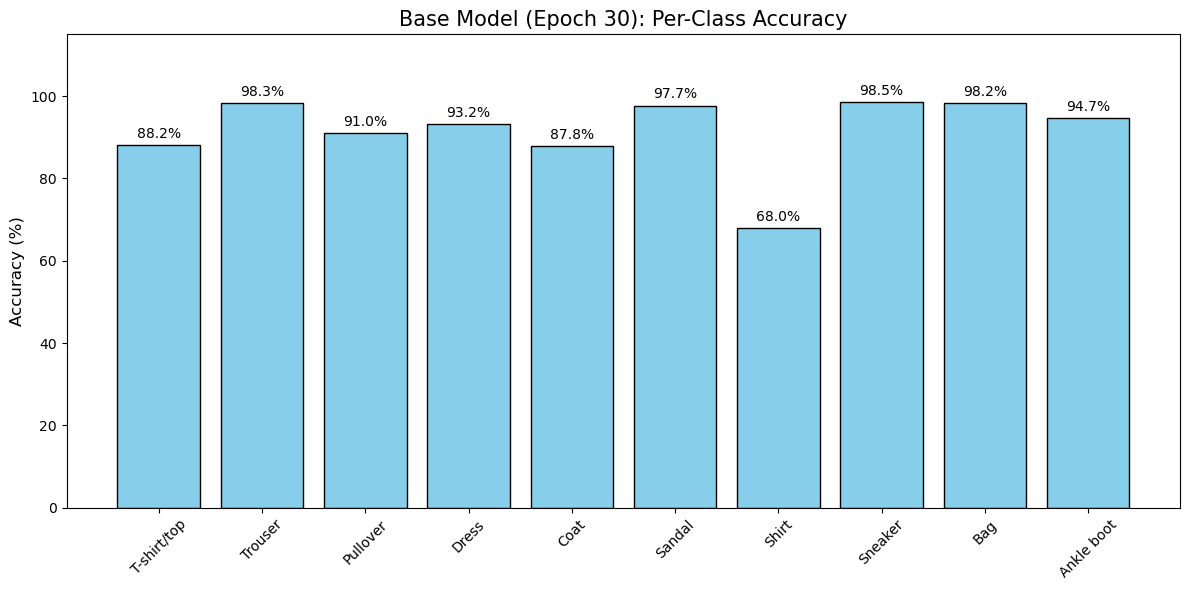

In [6]:
# 1단계: 초기 모델(Baseline) 학습

# 에포크별(5~30) 성능 측정
print("\n>>> 에포크별 성능 측정 (5 ~ 30)...")

epoch_list = range(5, 35, 5)
best_acc = 0.0
best_epoch = 0
best_classifier = None

for ep in epoch_list:
    # 모델 생성
    model = create_cnn_model()
    classifier = KerasClassifier(
        model=model,
        clip_values=(0.0, 1.0),
        use_logits=False
    )

    # 학습
    print(f"Testing Epoch {ep}...", end=" ")
    classifier.fit(x_train, y_train, batch_size=64, nb_epochs=ep)

    # 평가
    predictions = classifier.predict(x_test)
    y_pred_temp = np.argmax(predictions, axis=1)
    y_true_temp = np.argmax(y_test, axis=1)

    current_acc = np.mean(y_pred_temp == y_true_temp) * 100
    print(f"-> Accuracy: {current_acc:.2f}%")

    if current_acc > best_acc:
        best_acc = current_acc
        best_epoch = ep
        best_classifier = classifier

base_classifier = best_classifier # baseline 모델
acc_step1 = best_acc # baseline 모델 accuracy 저장

# Best 결과 출력 및 그래프
print("\n" + "="*50)
print(f" Best Result: Epoch {best_epoch} (Accuracy: {best_acc:.2f}%)")
print("="*50)

# 클래스별 accuracy
predictions = best_classifier.predict(x_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_acc_list = []
print(f"\n[Base Model (Epoch {best_epoch}) 클래스별 상세 정확도]")
for i, name in enumerate(class_names):
    indices = np.where(y_true == i)[0]
    class_acc = np.mean(y_pred[indices] == y_true[indices]) * 100
    class_acc_list.append(class_acc)
    print(f"{name:<15} | {class_acc:.2f}%")

# 그래프 그리기
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_acc_list, color='skyblue', edgecolor='black')
plt.title(f'Base Model (Epoch {best_epoch}): Per-Class Accuracy', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 115)
plt.xticks(rotation=45)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{bar.get_height():.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


>>> Epsilon 값에 따른 accuracy 변화 측정
기준 정확도: 91.56%
-----------------------------------------------------------------
Epsilon    | Accuracy   | Drop(Slope)     | Status
-----------------------------------------------------------------
0.01       | 87.36     % | -4.20          % | 
0.02       | 78.62     % | -8.74          % | 
0.03       | 68.47     % | -10.15         % | 
0.04       | 58.94     % | -9.53          % | 
0.05       | 50.60     % | -8.34          % | 
0.06       | 43.42     % | -7.18          % | 
0.07       | 37.38     % | -6.04          % | 
0.08       | 32.52     % | -4.86          % | 
0.09       | 28.49     % | -4.03          % | 
0.10       | 25.03     % | -3.46          % | 
0.11       | 22.09     % | -2.94          % | 
0.12       | 19.22     % | -2.87          % | 
0.13       | 16.96     % | -2.26          % | 
0.14       | 15.17     % | -1.79          % | 
0.15       | 13.79     % | -1.38          % | 
0.16       | 12.81     % | -0.98          % | Optimal Epsilon
0

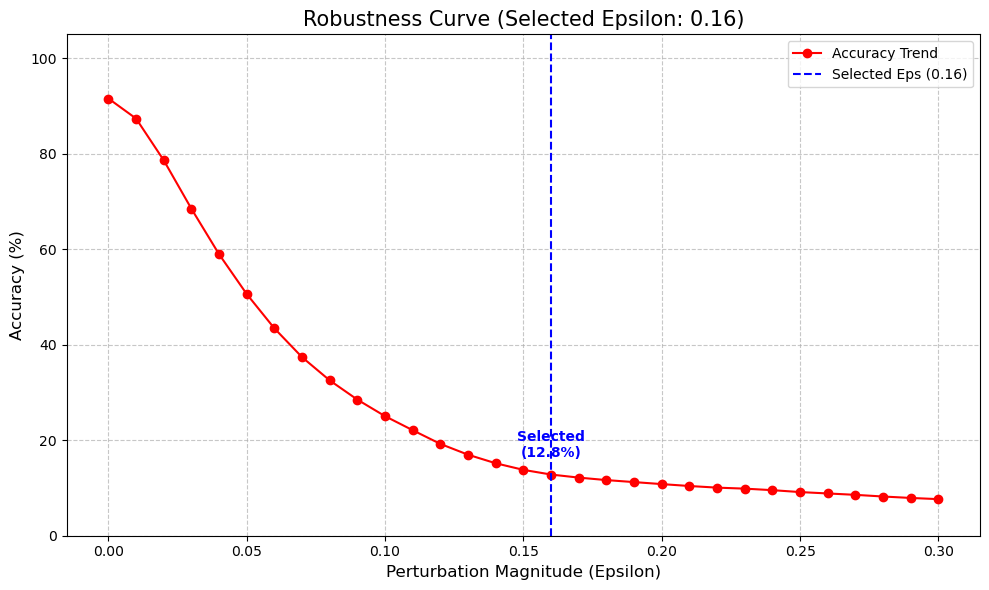

In [7]:
# 2단계: 공격(Attack) 수행 (FGSM)
print("\n>>> Epsilon 값에 따른 accuracy 변화 측정")
base_acc = best_acc

# epsilon 값 0.01 ~ 0.30까지 변화
epsilon_values = [round(x, 2) for x in np.arange(0.01, 0.31, 0.01)]
threshold_slope = 1.0  # 기울기가 1% 미만이면 완만하다고 판단

eps_history = [0.0] + epsilon_values
acc_history = [base_acc]
optimal_eps = None

# 최적의 적대적 예제 데이터를 담을 변수 초기화
final_adv_data = None

print(f"기준 정확도: {base_acc:.2f}%")
print("-" * 65)
print(f"{'Epsilon':<10} | {'Accuracy':<10} | {'Drop(Slope)':<15} | {'Status'}")
print("-" * 65)

# 2. 반복 실험 및 기울기 계산
for i, eps in enumerate(epsilon_values):
    # 공격 수행
    attacker = FastGradientMethod(estimator=best_classifier, eps=eps)
    x_test_adv = attacker.generate(x=x_test)

    # 예측 및 정확도 계산
    pred_adv = best_classifier.predict(x_test_adv)
    y_pred = np.argmax(pred_adv, axis=1)
    y_true = np.argmax(y_test, axis=1)

    curr_acc = np.mean(y_pred == y_true) * 100
    acc_history.append(curr_acc)

    # 기울기(하락폭) 계산
    prev_acc = acc_history[-2]
    slope = prev_acc - curr_acc

    # 추천 입실론 판단 및 데이터 저장
    status = ""
    # 조건: 아직 최적값이 없고, 기울기가 임계값보다 작을 때
    if optimal_eps is None and slope < threshold_slope:
        optimal_eps = eps
        status = "Optimal Epsilon"

        # 이때의 공격 받은 데이터셋 별도 변수에 백업
        final_adv_data = x_test_adv.copy()
        acc_step2 = curr_acc

    print(f"{eps:<10.2f} | {curr_acc:<10.2f}% | -{slope:<14.2f}% | {status}")

print("-" * 65)
print(f"-> 최종 선택 Epsilon: {optimal_eps}")

print(f"-> FGSM 공격에 대한 baseline 모델의 accuracy : {acc_step2}%")


# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(eps_history, acc_history, marker='o', linestyle='-', color='red', label='Accuracy Trend')

# 선택된 지점 수직선 표시
plt.axvline(x=optimal_eps, color='blue', linestyle='--', label=f'Selected Eps ({optimal_eps})')

plt.title(f'Robustness Curve (Selected Epsilon: {optimal_eps})', fontsize=15)
plt.xlabel('Perturbation Magnitude (Epsilon)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(0.0, 0.31, 0.05))
plt.ylim(0, 105)
plt.legend()

# 선택된 지점에 텍스트 표시
sel_idx = eps_history.index(optimal_eps)
sel_acc = acc_history[sel_idx]
plt.text(optimal_eps, sel_acc + 3, f'Selected\n({sel_acc:.1f}%)',
         ha='center', va='bottom', color='blue', fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
# 적대적 학습 대상 모델 비교
import copy

print("\n" + "=" * 70)
print(">>> FGSM 적대적 학습 대상 모델 비교")
print(f">>> 설정: Epsilon={optimal_eps}, Ratio=0.5")
print("=" * 70)

# 공통 설정
epsilon = optimal_eps
fixed_ratio = 0.5
fixed_epochs = 10 
y_true = np.argmax(y_test, axis=1)


# 기존 학습된 모델에 추가 적대적 학습 (pre-trained)

print("\n[A] 기존 학습된 모델에 추가 적대적 학습")

#원본 모델 오염 방지를 위해 복제본 생성
model_ft = tf.keras.models.clone_model(best_classifier.model) 
model_ft.set_weights(best_classifier.model.get_weights()) # 1단계 학습 상태 복사

# ART Classifier로 다시 감싸기
classifier_ft = KerasClassifier(model=model_ft, clip_values=(0, 1), use_logits=False)

# 공격 및 방어 객체 생성
attacker_ft = FastGradientMethod(estimator=classifier_ft, eps=epsilon)
trainer_ft = AdversarialTrainer(classifier_ft, attacks=attacker_ft, ratio=fixed_ratio)

# 학습 수행 (10 epoch 추가)
trainer_ft.fit(x_train, y_train, batch_size=64, nb_epochs=fixed_epochs)

# 성능 평가
attacker_eval_ft = FastGradientMethod(estimator=classifier_ft, eps=epsilon)
x_adv_ft = attacker_eval_ft.generate(x_test)
acc_ft = np.mean(np.argmax(classifier_ft.predict(x_adv_ft), axis=1) == y_true) * 100
print(f"   -> 완료: Accuracy {acc_ft:.2f}%")
acc_step3 = acc_ft


# 완전히 새로운 모델 생성 + FGSM (From Scratch)

print("\n[B] 완전히 새로운 모델 생성 + 적대적 학습")

model_scratch = create_cnn_model()
classifier_scratch = KerasClassifier(model=model_scratch, clip_values=(0, 1), use_logits=False)

attacker_scr = FastGradientMethod(estimator=classifier_scratch, eps=epsilon)
trainer_scr = AdversarialTrainer(classifier_scratch, attacks=attacker_scr, ratio=fixed_ratio)

print(f"   -> 학습 에포크 설정: {fixed_epochs}회")

trainer_scr.fit(x_train, y_train, batch_size=64, nb_epochs=fixed_epochs)

# 성능 평가
attacker_eval_scr = FastGradientMethod(estimator=classifier_scratch, eps=epsilon)
x_adv_scr = attacker_eval_scr.generate(x_test)
acc_scr = np.mean(np.argmax(classifier_scratch.predict(x_adv_scr), axis=1) == y_true) * 100
print(f"   -> 완료: Accuracy {acc_scr:.2f}%")

# 최종 결과 출력

print("\n" + "=" * 70)
print(f"{'Strategy':<40} | {'Robust Accuracy':<20}")
print("-" * 70)
print(f"{'기존 학습된 모델에 추가 적대적 학습 (Pre-trained)':<40} | {acc_ft:.2f}%")
print(f"{'새로운 모델에 적대적 학습 (New Model)':<40} | {acc_scr:.2f}%")
print("=" * 70)


>>> FGSM 적대적 학습 대상 모델 비교
>>> 설정: Epsilon=0.16, Ratio=0.5

[A] 기존 학습된 모델에 추가 적대적 학습


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

   -> 완료: Accuracy 84.34%

[B] 완전히 새로운 모델 생성 + 적대적 학습
   -> 학습 에포크 설정: 10회


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

   -> 완료: Accuracy 77.42%

Strategy                                 | Robust Accuracy     
----------------------------------------------------------------------
기존 학습된 모델에 추가 적대적 학습 (Pre-trained)       | 84.34%
새로운 모델에 적대적 학습 (New Model)               | 77.42%


In [9]:
# 모델 가중치 백업
if 'clean_weights_backup' not in globals():
    clean_weights_backup = best_classifier.model.get_weights()
else:
    best_classifier.model.set_weights(clean_weights_backup)


In [10]:
# 공격 데이터에 따른 성능 비교
epsilon = optimal_eps  # 이전 단계에서 구한 최적 입실론 사용

print(f"학습 설정: Epsilon={epsilon}, Ratio=0.5, Epochs=10")
print("공격 데이터에 따른 성능 비교")

# 공격 객체 생성 (학습용)
attacker_train = FastGradientMethod(estimator=best_classifier, eps=epsilon)

# 적대적 학습기 생성 (Ratio=0.5: 원본 50% + 적대적 예제 50% 혼합)
trainer = AdversarialTrainer(best_classifier, attacks=attacker_train, ratio=0.5)

# 학습 수행 (best_classifier의 가중치가 업데이트됨)
trainer.fit(x_train, y_train, batch_size=64, nb_epochs=10)


# 새로운 공격에 대한 방어력 측정
print(">>> 1. 방어된 모델에 대한 '새로운 공격(Re-attack)' 시도")

# 현재의 강해진 모델을 기준으로 다시 공격 생성
attacker_robust = FastGradientMethod(estimator=best_classifier, eps=epsilon)
x_test_adv_robust = attacker_robust.generate(x=x_test)

# 예측 및 정확도 계산
predictions_robust_adv = np.argmax(best_classifier.predict(x_test_adv_robust), axis=1)
y_true = np.argmax(y_test, axis=1)
acc_step3 = np.sum(predictions_robust_adv == y_true) / len(y_test) * 100

print(f"   -> 새로운 공격에 대한 모델의 성능 = {acc_step3:.2f}%")


# 과거 공격 데이터에 대한 방어력 측정
print("\n>>> 2. 저장된 '이전 공격 데이터(final_adv_data)'에 대한 모델의 성능 측정")

# 저장해둔 데이터로 예측 수행 (데이터가 있을 때만 수행)
preds_saved_adv = best_classifier.predict(final_adv_data)
y_pred_saved = np.argmax(preds_saved_adv, axis=1)
acc_saved_adv = np.mean(y_pred_saved == y_true) * 100

print(f"   -> 저장된 적대적 예제(과거의 공격)에 대한 정확도 = {acc_saved_adv:.2f}%")
    


학습 설정: Epsilon=0.16, Ratio=0.5, Epochs=10
공격 데이터에 따른 성능 비교


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

>>> 1. 방어된 모델에 대한 '새로운 공격(Re-attack)' 시도
   -> 새로운 공격에 대한 모델의 성능 = 85.63%

>>> 2. 저장된 '이전 공격 데이터(final_adv_data)'에 대한 모델의 성능 측정
   -> 저장된 적대적 예제(과거의 공격)에 대한 정확도 = 89.20%



>>> Ratio 비율(0.2, 0.5, 0.8)에 따른 Accuracy 변화 분석 (Clean vs Robust)
[*] 실험 Epsilon: 0.16
[*] 비교할 Ratio 목록: [0.2, 0.5, 0.8]

--- [Experiment] Ratio: 0.2 진행 중 ---


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

   -> [Clean ] 원본 데이터에 대한 정확도: 91.03%
   -> [Robust] 공격 받은 데이터에 대한 정확도: 84.26%

--- [Experiment] Ratio: 0.5 진행 중 ---


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

   -> [Clean ] 원본 데이터에 대한 정확도: 90.50%
   -> [Robust] 공격 받은 데이터에 대한 정확도: 85.32%

--- [Experiment] Ratio: 0.8 진행 중 ---


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

   -> [Clean ] 원본 데이터에 대한 정확도: 88.88%
   -> [Robust] 공격 받은 데이터에 대한 정확도: 83.21%

-----------------------------------------------------------------
📊 [Result Summary] Ratio별 성능 트레이드오프 (Eps=0.16)
-----------------------------------------------------------------
Ratio      | Clean Acc       | Robust Acc     
-----------------------------------------------------------------
0.2        | 91.03          % | 84.26          %
0.5        | 90.50          % | 85.32          %
0.8        | 88.88          % | 83.21          %
-----------------------------------------------------------------


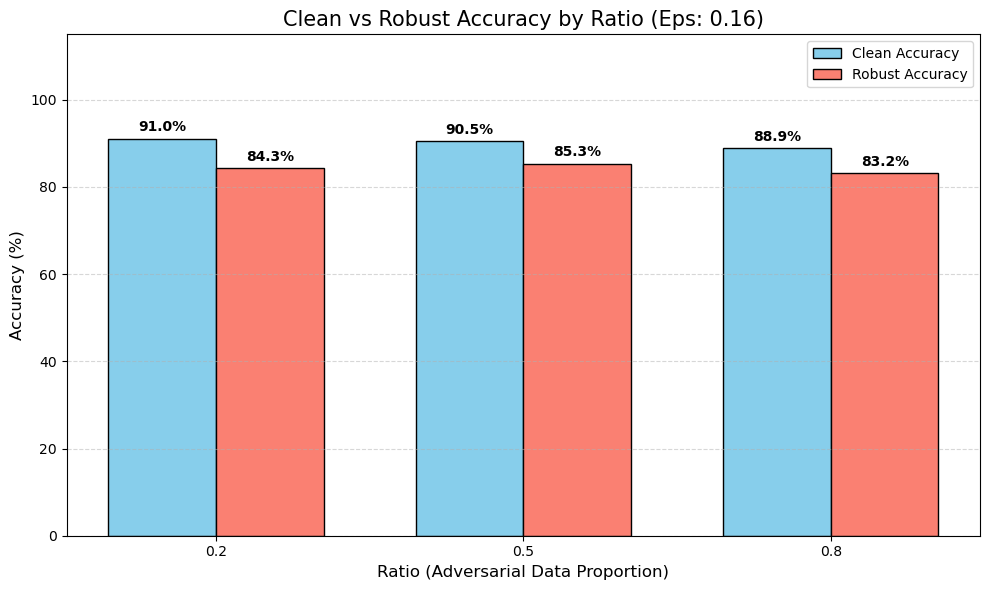

In [11]:
# 적대적 학습 비율(ratio)에 따른 비교 실험
print("\n" + "=" * 65)
print(">>> Ratio 비율(0.2, 0.5, 0.8)에 따른 Accuracy 변화 분석 (Clean vs Robust)")
print("=" * 65)

# 1. 실험 설정
ratios = [0.2, 0.5, 0.8]
ratio_results = []       # 방어(Robust) 정확도 저장
clean_acc_results = []   # 정상(Clean) 정확도 저장
epsilon = optimal_eps

print(f"[*] 실험 Epsilon: {epsilon}")
print(f"[*] 비교할 Ratio 목록: {ratios}\n")


# 2. 반복 실험 수행
for r in ratios:
    print(f"--- [Experiment] Ratio: {r} 진행 중 ---")
    
    best_classifier.model.set_weights(clean_weights_backup)
    
    # 적대적 학습 수행
    attacker_train = FastGradientMethod(estimator=best_classifier, eps=epsilon)
    trainer = AdversarialTrainer(best_classifier, attacks=attacker_train, ratio=r)
    
    trainer.fit(x_train, y_train, batch_size=64, nb_epochs=10)
    
    # 원본 데이터(Clean Data)에 대한 정확도 측정
    clean_pred = np.argmax(best_classifier.predict(x_test), axis=1)
    clean_acc = np.mean(clean_pred == y_true) * 100
    clean_acc_results.append(clean_acc)

    # 적대적 예제(Robust Data)에 대한 정확도 측정
    attacker_eval = FastGradientMethod(estimator=best_classifier, eps=epsilon)
    x_adv_eval = attacker_eval.generate(x=x_test)
    
    y_pred = np.argmax(best_classifier.predict(x_adv_eval), axis=1)
    acc = np.mean(y_pred == y_true) * 100
    ratio_results.append(acc)
    
    # 결과 출력
    print(f"   -> [Clean ] 원본 데이터에 대한 정확도: {clean_acc:.2f}%")
    print(f"   -> [Robust] 공격 받은 데이터에 대한 정확도: {acc:.2f}%")
    print("")
    
# 모든 실험 종료 후 모델 초기화 
best_classifier.model.set_weights(clean_weights_backup)

# 3. 결과 요약 및 시각화
print("-" * 65)
print(f"Ratio별 성능 트레이드오프 (Eps={epsilon})")
print("-" * 65)
print(f"{'Ratio':<10} | {'Clean Acc':<15} | {'Robust Acc':<15}")
print("-" * 65)

for r, c_acc, r_acc in zip(ratios, clean_acc_results, ratio_results):
    print(f"{r:<10} | {c_acc:<15.2f}% | {r_acc:<15.2f}%")
print("-" * 65)

# 시각화 (Grouped Bar Chart)
x = np.arange(len(ratios))  # 라벨 위치
width = 0.35  # 막대 너비

plt.figure(figsize=(10, 6))
rects1 = plt.bar(x - width/2, clean_acc_results, width, label='Clean Accuracy', color='skyblue', edgecolor='black')
rects2 = plt.bar(x + width/2, ratio_results, width, label='Robust Accuracy', color='salmon', edgecolor='black')

plt.xlabel('Ratio (Adversarial Data Proportion)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title(f'Clean vs Robust Accuracy by Ratio (Eps: {epsilon})', fontsize=15)
plt.xticks(x, ratios)
plt.ylim(0, 115) # 텍스트 공간 확보
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위에 값 표시 함수
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


>>> Epsilon 변화(0.01 ~ 0.25)에 따른 Accuracy 분석 (Fixed Ratio=0.5)
[*] 고정 Ratio: 0.5
[*] 비교할 Epsilon 목록: [0.01 0.06 0.11 0.16 0.21]

--- [Experiment] Epsilon: 0.01 (Ratio: 0.5) 진행 중 ---


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

   -> [Clean ] 원본 정확도: 91.40%
   -> [Robust] 방어 정확도: 89.16%

--- [Experiment] Epsilon: 0.06 (Ratio: 0.5) 진행 중 ---


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

   -> [Clean ] 원본 정확도: 90.46%
   -> [Robust] 방어 정확도: 80.71%

--- [Experiment] Epsilon: 0.11 (Ratio: 0.5) 진행 중 ---


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

   -> [Clean ] 원본 정확도: 89.89%
   -> [Robust] 방어 정확도: 82.26%

--- [Experiment] Epsilon: 0.16 (Ratio: 0.5) 진행 중 ---


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

   -> [Clean ] 원본 정확도: 89.94%
   -> [Robust] 방어 정확도: 83.76%

--- [Experiment] Epsilon: 0.21 (Ratio: 0.5) 진행 중 ---


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

   -> [Clean ] 원본 정확도: 90.74%
   -> [Robust] 방어 정확도: 86.14%

-----------------------------------------------------------------
📊 [Result Summary] Epsilon별 성능 변화 (Ratio=0.5)
-----------------------------------------------------------------
Epsilon    | Clean Acc       | Robust Acc     
-----------------------------------------------------------------
0.01       | 91.40          % | 89.16          %
0.06       | 90.46          % | 80.71          %
0.11       | 89.89          % | 82.26          %
0.16       | 89.94          % | 83.76          %
0.21       | 90.74          % | 86.14          %
-----------------------------------------------------------------


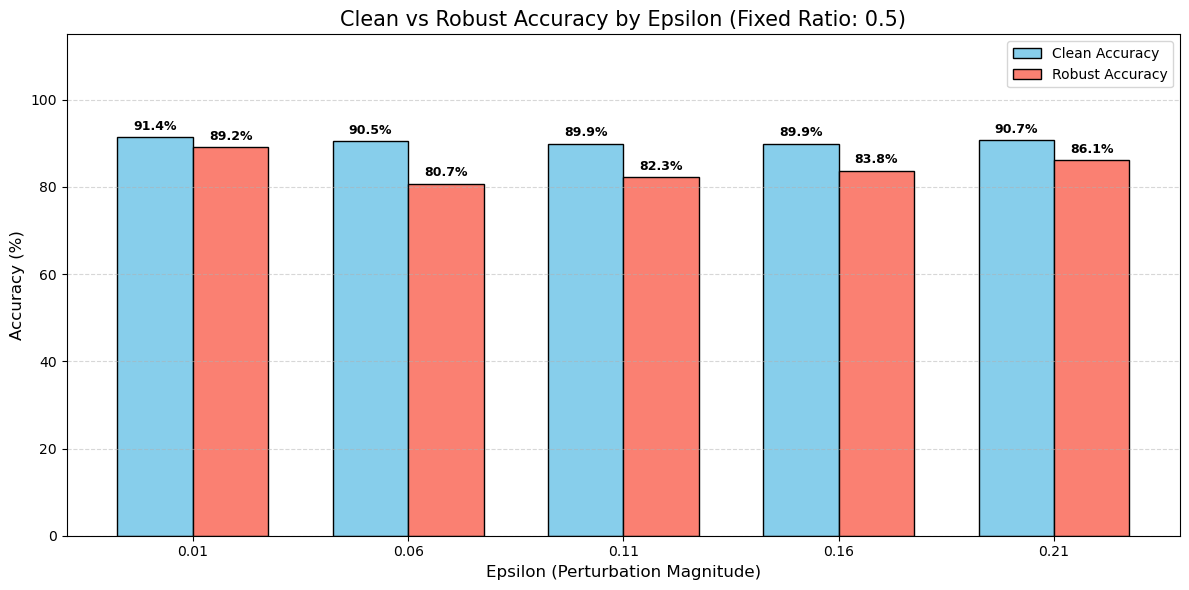

In [12]:
# 적대적 학습 Epsilon 변화에 따른 비교 실험
print("\n" + "=" * 65)
print(">>> Epsilon 변화(0.01 ~ 0.25)에 따른 Accuracy 분석 (Fixed Ratio=0.5)")
print("=" * 65)

# 1. 실험 설정
# 0.01부터 0.22전까지 0.05 간격
epsilons = np.arange(0.01, 0.22, 0.05) 
fixed_ratio = 0.5

clean_acc_results = []   # 정상(Clean) 정확도 저장
robust_acc_results = []  # 방어(Robust) 정확도 저장

print(f"[*] 고정 Ratio: {fixed_ratio}")
print(f"[*] 비교할 Epsilon 목록: {np.round(epsilons, 2)}\n")

# 2. 반복 실험 수행
for eps in epsilons:

    eps = round(eps, 2)
    
    print(f"--- [Experiment] Epsilon: {eps} (Ratio: {fixed_ratio}) 진행 중 ---")
    
    best_classifier.model.set_weights(clean_weights_backup)
    
    # 공격자 생성 (Train용)
    attacker_train = FastGradientMethod(estimator=best_classifier, eps=eps)
    
    # 트레이너 생성 
    trainer = AdversarialTrainer(best_classifier, attacks=attacker_train, ratio=fixed_ratio)
    
    # 학습 수행
    trainer.fit(x_train, y_train, batch_size=64, nb_epochs=10)
    
    # 원본 데이터(Clean Data)에 대한 정확도 측정
    clean_pred = np.argmax(best_classifier.predict(x_test), axis=1)
    clean_acc = np.mean(clean_pred == y_true) * 100
    clean_acc_results.append(clean_acc)

    # 적대적 예제(Robust Data)에 대한 정확도 측정
    attacker_eval = FastGradientMethod(estimator=best_classifier, eps=eps)
    x_adv_eval = attacker_eval.generate(x=x_test)
    
    adv_pred = np.argmax(best_classifier.predict(x_adv_eval), axis=1)
    robust_acc = np.mean(adv_pred == y_true) * 100
    robust_acc_results.append(robust_acc)
    
    # 결과 출력
    print(f"   -> [Clean ] 원본 정확도: {clean_acc:.2f}%")
    print(f"   -> [Robust] 방어 정확도: {robust_acc:.2f}%")
    print("")

# 모든 실험 종료 후 모델 초기화
best_classifier.model.set_weights(clean_weights_backup)

# 3. 결과 요약 및 시각화
print("-" * 65)
print(f"Epsilon별 성능 변화 (Ratio={fixed_ratio})")
print("-" * 65)
print(f"{'Epsilon':<10} | {'Clean Acc':<15} | {'Robust Acc':<15}")
print("-" * 65)

for eps, c_acc, r_acc in zip(epsilons, clean_acc_results, robust_acc_results):
    print(f"{eps:<10.2f} | {c_acc:<15.2f}% | {r_acc:<15.2f}%")
print("-" * 65)

# 시각화 (Grouped Bar Chart)
x = np.arange(len(epsilons))  # 라벨 위치
width = 0.35  # 막대 너비

plt.figure(figsize=(12, 6))
rects1 = plt.bar(x - width/2, clean_acc_results, width, label='Clean Accuracy', color='skyblue', edgecolor='black')
rects2 = plt.bar(x + width/2, robust_acc_results, width, label='Robust Accuracy', color='salmon', edgecolor='black')

plt.xlabel('Epsilon (Perturbation Magnitude)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title(f'Clean vs Robust Accuracy by Epsilon (Fixed Ratio: {fixed_ratio})', fontsize=15)
plt.xticks(x, np.round(epsilons, 2)) # X축 라벨을 Epsilon 값으로 설정
plt.ylim(0, 115) # 텍스트 공간 확보
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위에 값 표시 함수
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()